In [8]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split

from mapie.conformity_scores.residual_conformity_scores import GPConformityScore
from mapie.regression import MapieRegressor

plt.rcParams["figure.dpi"]=300
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
BLUE = np.array([[26, 54, 105]]) / 255
ORANGE = np.array([[223, 84, 49]]) / 255
YELLOW = np.array([[242, 188, 64]]) / 255


In [10]:
def g(x):
    return (3 * x * np.sin(x) - 2 * x * np.cos(x) + ( x ** 3) / 40 - .5 * x ** 2 - 10 * x)

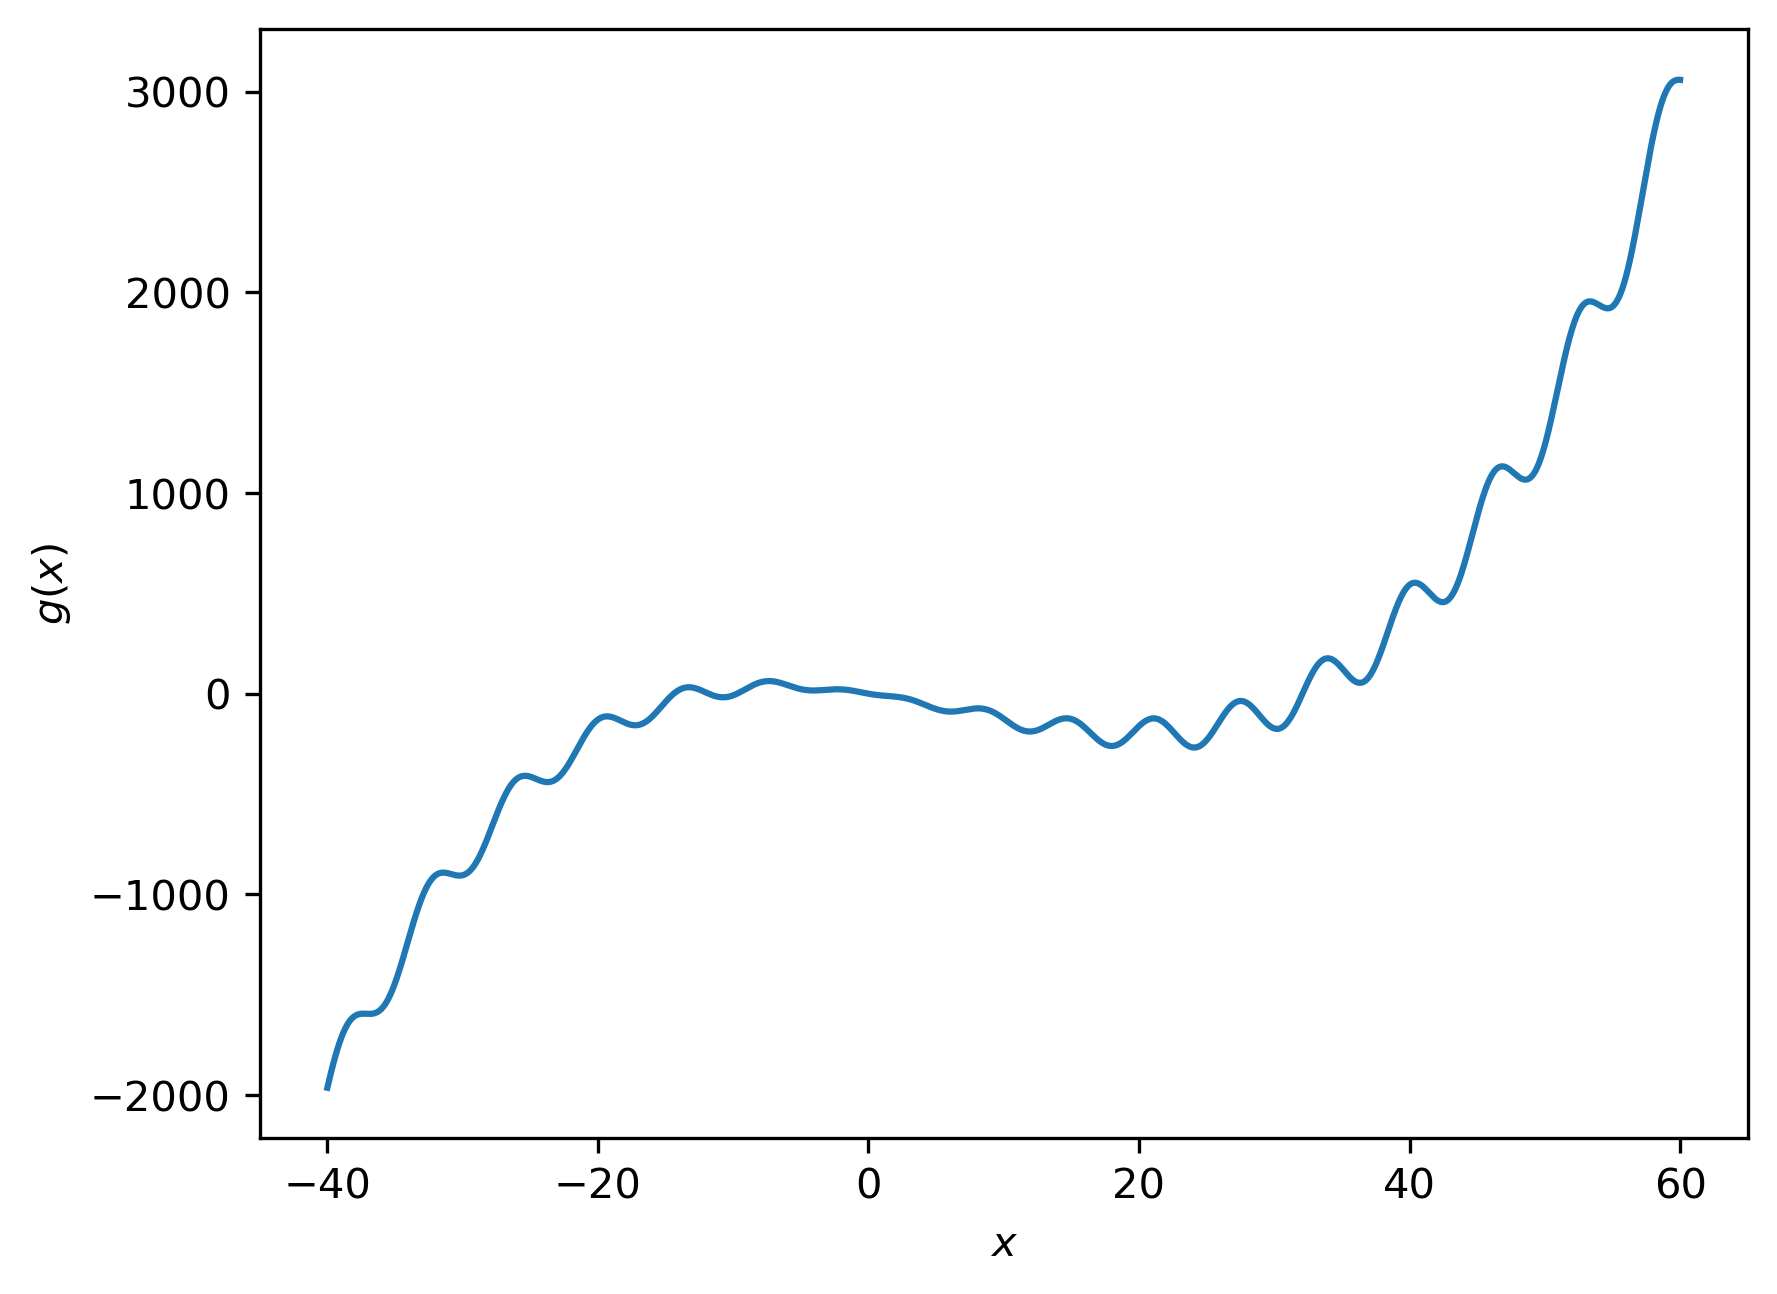

In [11]:
x_mesh = np.linspace(-40, 60, 5000)
plt.plot(x_mesh, g(x_mesh))
plt.xlabel("$x$")
plt.ylabel("$g(x)$")
plt.savefig("../plots/toy_function.png")


In [5]:
X_train, X_test, y_train, y_test = train_test_split(x_mesh, g(x_mesh), test_size=.98, random_state=42)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

In [6]:
print(
    f"  N training points = {len(X_train)}\n",
    f" N testing points = {len(X_test)}"
)

  N training points = 100
  N testing points = 4900


In [7]:
gp = GaussianProcessRegressor(normalize_y=True)

In [8]:
gp.fit(X_train, y_train)

GaussianProcessRegressor(normalize_y=True)

# Fit and Predict with MAPIE

In [9]:
mapie_j_plus_gp = MapieRegressor(
    estimator=gp,
    cv=-1,
    method="plus",
    conformity_score=GPConformityScore(),
    model_has_std=True,
    random_state=42
)

mapie_j_plus = MapieRegressor(
    estimator=gp,
    cv=-1,
    method="plus",
    conformity_score=None,
    model_has_std=False,
    random_state=42
)


mapie_j_plus_gp.fit(X_train, y_train)
mapie_j_plus.fit(X_train, y_train)


MapieRegressor(cv=-1, estimator=GaussianProcessRegressor(normalize_y=True),
               random_state=42)

In [10]:
ALPHA = .1

_, y_pss_j_plus_gp = mapie_j_plus_gp.predict(x_mesh.reshape(-1, 1), alpha=ALPHA)
_, y_pss_j_plus = mapie_j_plus.predict(x_mesh.reshape(-1, 1), alpha=ALPHA)

y_mean, y_std = gp.predict(x_mesh.reshape(-1, 1), return_std=True)

In [11]:
q_alpha_min = scipy.stats.norm.ppf(ALPHA / 2)
q_alpha_max = scipy.stats.norm.ppf(1 - ALPHA / 2)

NameError: name 'X_train' is not defined

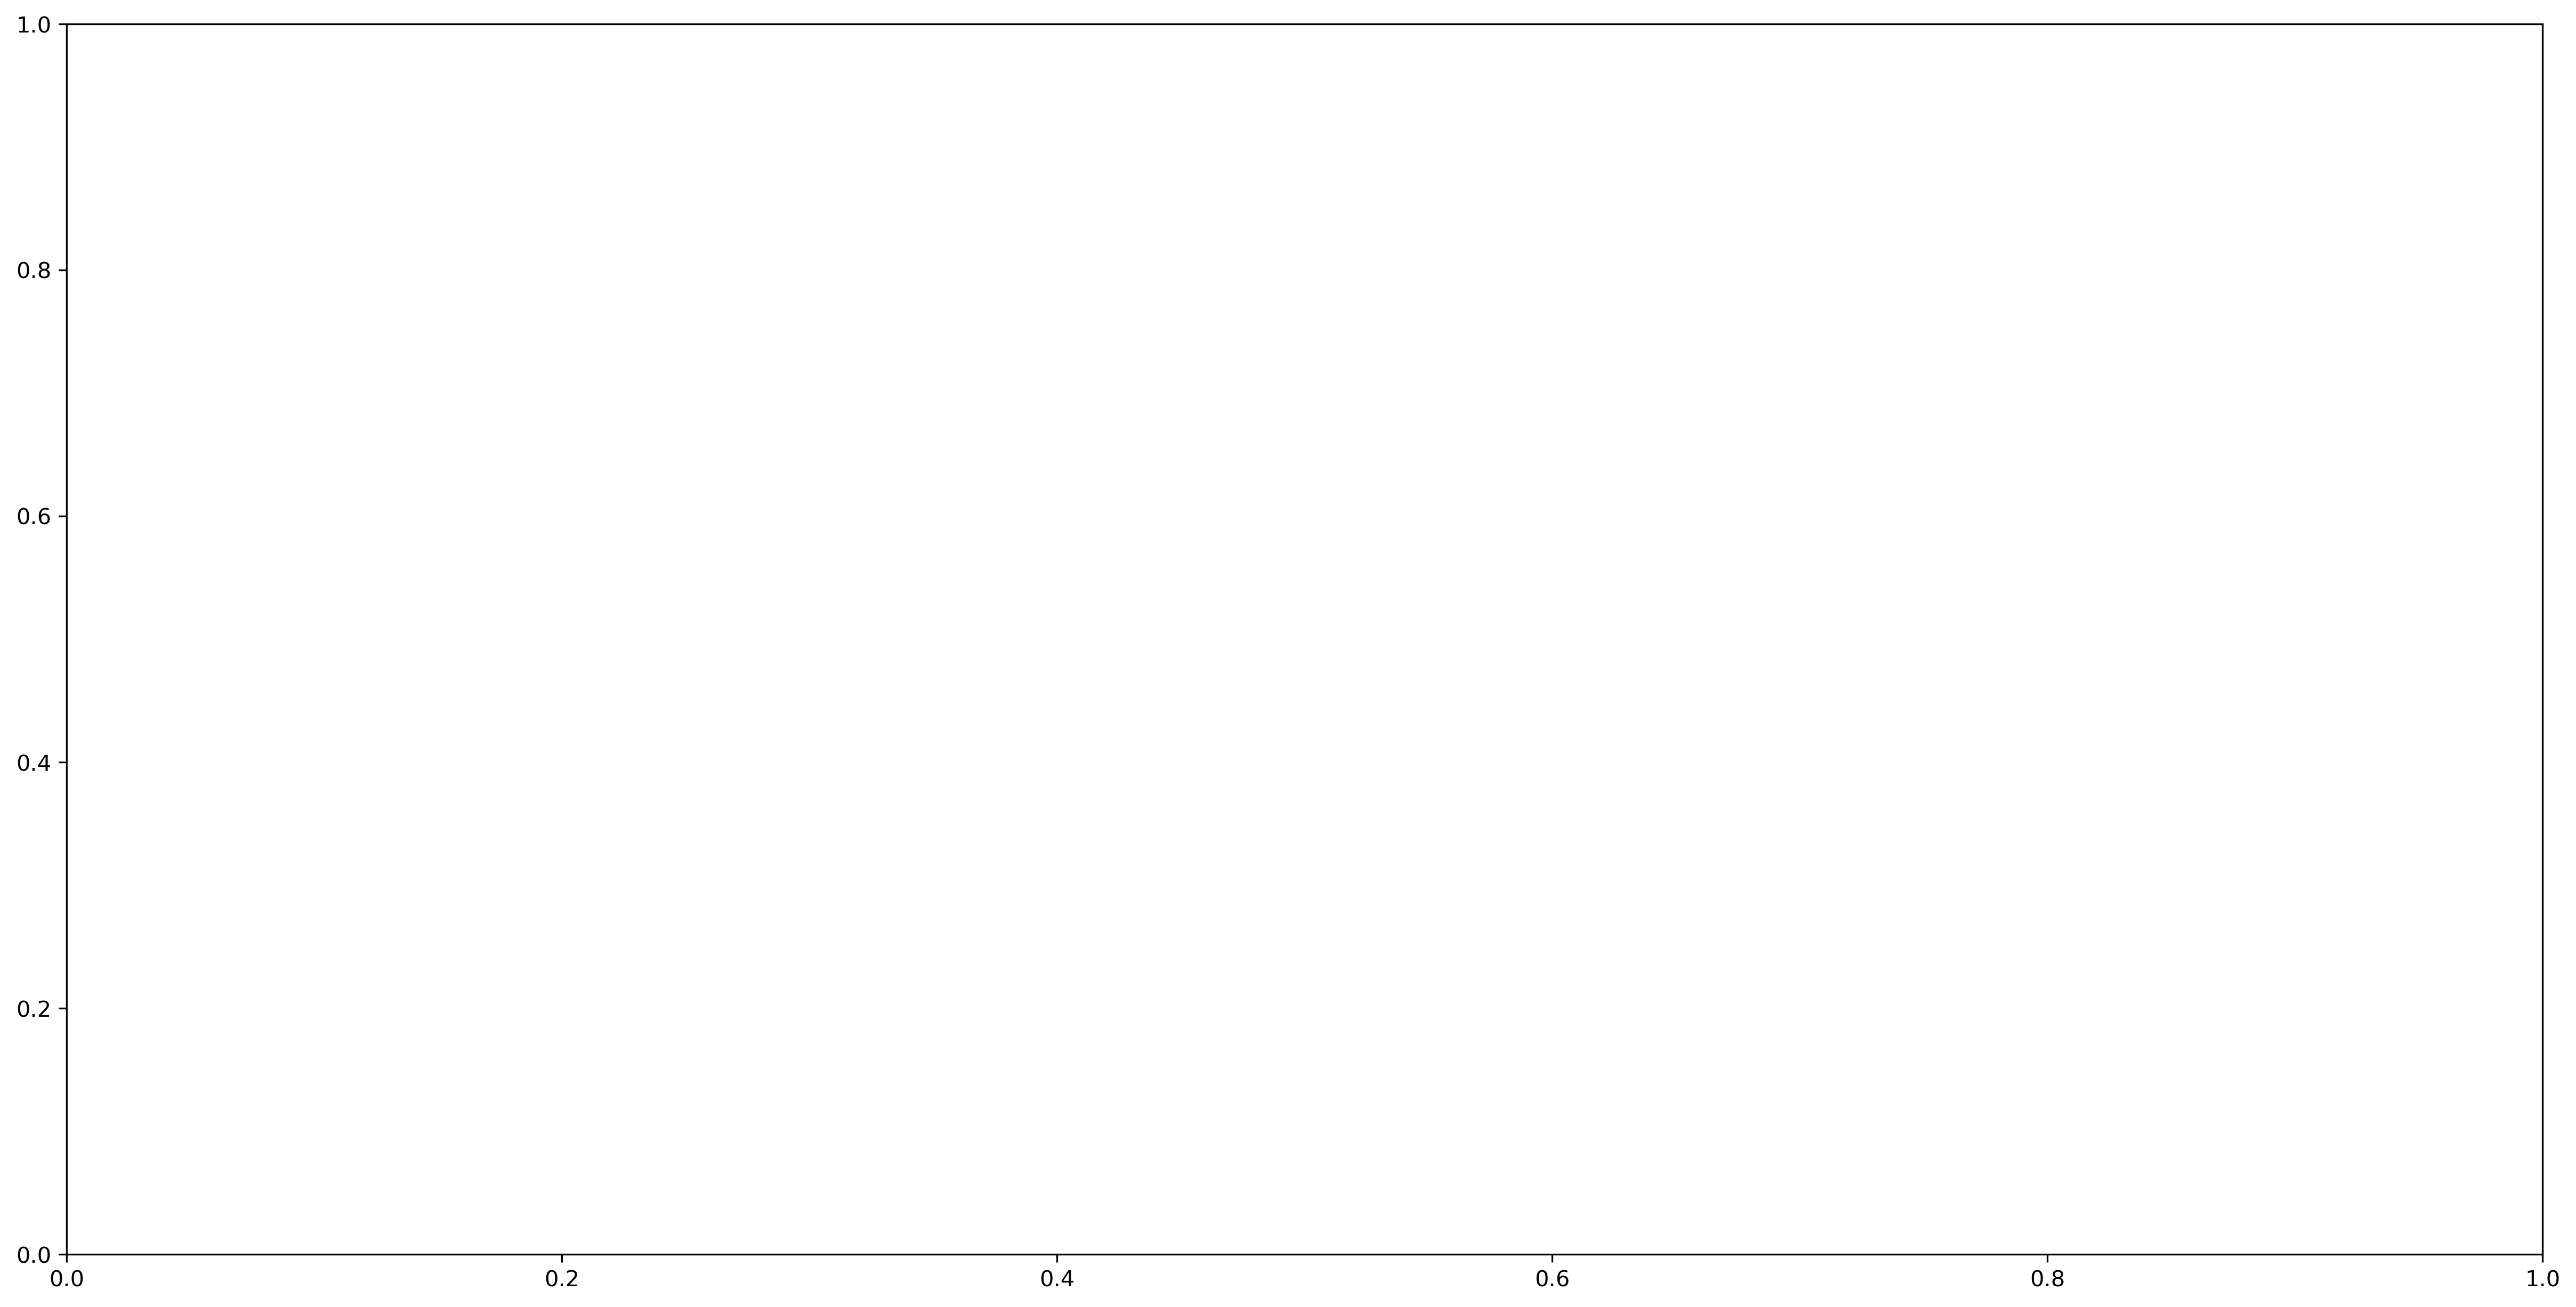

In [7]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter(X_train, y_train, c=BLUE)


ax.plot(x_mesh, g(x_mesh), c=BLUE)
ax.plot(x_mesh, y_mean, c=YELLOW)
ax.fill_between(
        x_mesh,
        y_mean + y_std * q_alpha_min,
        y_mean + y_std * q_alpha_max,
        alpha=0.3,
        color=YELLOW,
        label=r"$\pm$ 1 std. dev.",
    )


ax.fill_between(
        x_mesh,
        y_pss_j_plus_gp[:, 0, 0],
        y_pss_j_plus_gp[:, 1, 0],
        alpha=.6,
        color=ORANGE,
        label=r"$\pm$ 1 std. dev.",
    )

ax.fill_between(
        x_mesh,
        y_pss_j_plus[:, 0, 0],
        y_pss_j_plus[:, 1, 0],
        alpha=.3,
        color="g",
        label=r"$\pm$ 1 std. dev.",
    )
ax.legend(
    [
        "Training Points",
        "True function", "Mean of posterior GP",
        "Posterior GP Credibility Interval",
        "Prediction Interval J+GP",
         "Prediction Interval J+", 
    ]
)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.savefig("../plots/intervals_toy_function.png")
